# Setup

## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib

## Variables

### Dangerous Parameters

These may crash your kernel/device depending on your available resources.

In [2]:
# Preprocessing Batch Size
batch_size = 64
# Modelling Batch Size
modelling_batch_size = 32
# See `Model > Fit`
epochs_per_batch = 50
"""
Enables a *lot* of parallelism.
Speeds preprocessing & modelling up exponentially on a powerful device,
but may not work well otherwise.
"""
optimize = True

#### For comparison, this notebook was run on the following devices:

In [3]:
for device in device_lib.list_local_devices():
  print(device)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8759863878756750833
xla_global_id: -1

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3660578816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1751773022773499343
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



### Random

For deterministic results

In [4]:
def setRng():
  global rng
  rng = np.random.default_rng(2101432)
  return rng

rng = setRng()

def randint():
  return rng.integers(65535)

### Optimization

In [5]:
def mapOptimized(ds, *args, **kwargs):
  return ds.map(num_parallel_calls=tf.data.AUTOTUNE, *args, **kwargs)
def mapUnoptimized(ds, *args, **kwargs):
  return ds.map(*args, **kwargs)
map = mapOptimized if optimize else mapUnoptimized
def mapX(ds, fn):
  return map(ds, lambda x, y: (fn(x), y))

def batch(ds, batch_size=batch_size, *args, **kwargs):
  return ds.batch(batch_size, *args, **kwargs)
def passThrough(ds):
  return ds
def cacheOptimized(ds, *args, **kwargs):
  return ds.cache(*args, **kwargs)
cache = cacheOptimized if optimize else passThrough
def prefetchOptimized(ds, *args, **kwargs):
  return ds.prefetch(tf.data.AUTOTUNE, *args, **kwargs)
prefetch = prefetchOptimized if optimize else passThrough

### Dataset

In [6]:
ds_seed = randint()

In [7]:
ds = tf.keras.utils.image_dataset_from_directory(
  "data",
  batch_size=batch_size,
  label_mode="categorical",
  seed=ds_seed
)
class_names = ds.class_names
num_classes = len(class_names)

"""
Normalizing here smoothens many later processes, such as
- Visualization (no need to convert to int)
- Training (lower computation cost)
"""
@tf.function
def normalize(x, y):
  return x/255, y
ds = cache(map(ds, normalize))

Found 1032 files belonging to 10 classes.


### Helpers

In [8]:
# Scaling Factor for Visualizations
sf = 2.5

@tf.function
def extractLabels(image, label_categorical):
  return tf.argmax(label_categorical, 1)

def count_labels(labels):
  return tf.math.bincount(labels, minlength=num_classes)

def classInfos(ds):
  labels = list(prefetch(map(ds, extractLabels)).unbatch())
  unique_labels, _, class_counts = tf.unique_with_counts(labels)
  
  return labels, unique_labels.numpy(), class_counts.numpy()

def filterByLabel(label):
  @tf.function
  def _filterByLabel(image, label_categorical):
    return label_categorical[label] == 1
  return _filterByLabel

def uniqueLabelsToClassNames(unique_labels):
  return [class_names[label] for label in unique_labels]

# Exploration

## Metadata

In [9]:
example_image = next(iter(ds.take(1).unbatch().take(1).as_numpy_iterator()))[0]
image_shape = example_image.shape
target_size = image_shape[:2]

print(f"Image Shape: {image_shape}")

Image Shape: (256, 256, 3)


### Classes

In [10]:
num_classes_print = f"{num_classes} Classes"
print(num_classes_print, "-" * len(num_classes_print), sep="\n")

for label, class_name in enumerate(class_names):
  print(f"{label}: {class_name}")

10 Classes
----------
0: Carrot Cake
1: Chicken Rice
2: Congee
3: Hokkien Mee
4: Kaya Toast
5: Laksa
6: Lamb Soup
7: Nasi Lemak
8: Prata
9: Satay


#### Samples per class

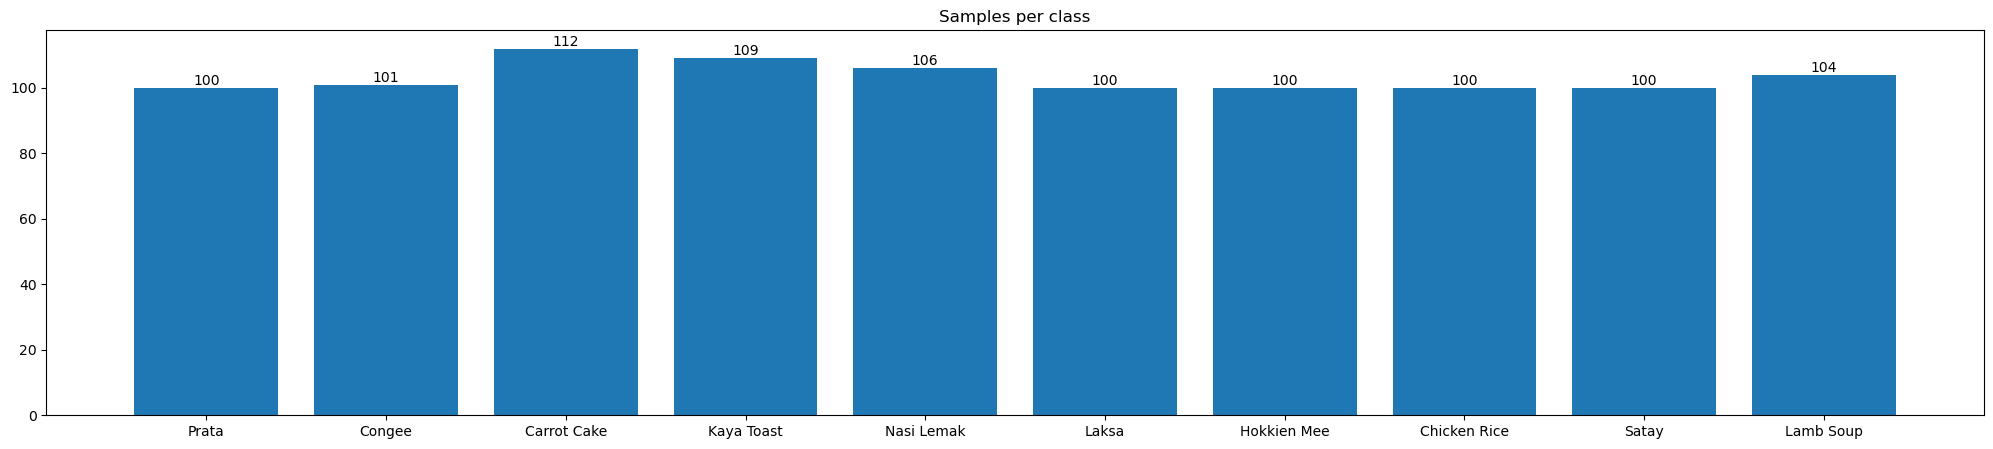

In [11]:
labels, unique_labels, class_counts = classInfos(ds)

plt.figure(figsize=(num_classes * sf, 5))
plt.bar_label(plt.bar(uniqueLabelsToClassNames(unique_labels), class_counts))
plt.title("Samples per class")
plt.show()

There seems to be a slight imbalance in samples per class

#### Examples by class

In [12]:
def examplesByClass(
  ds,
  examples_per_class,
  unique_labels=unique_labels
):
  num_classes = len(unique_labels)
  plt.figure(figsize=(examples_per_class * sf, num_classes * sf))

  for label_i, label in enumerate(unique_labels):
    examples = prefetch(
      ds
        .unbatch()
        .filter(filterByLabel(label))
        .take(examples_per_class)
    )
    zero_index = label_i * examples_per_class + 1
    for example_i, (image, label_categorical) in enumerate(examples):
      plt.subplot(num_classes, examples_per_class, zero_index + example_i)
      plt.imshow(image)
      if example_i == 0:
        plt.title(class_names[label])
      plt.axis("off")

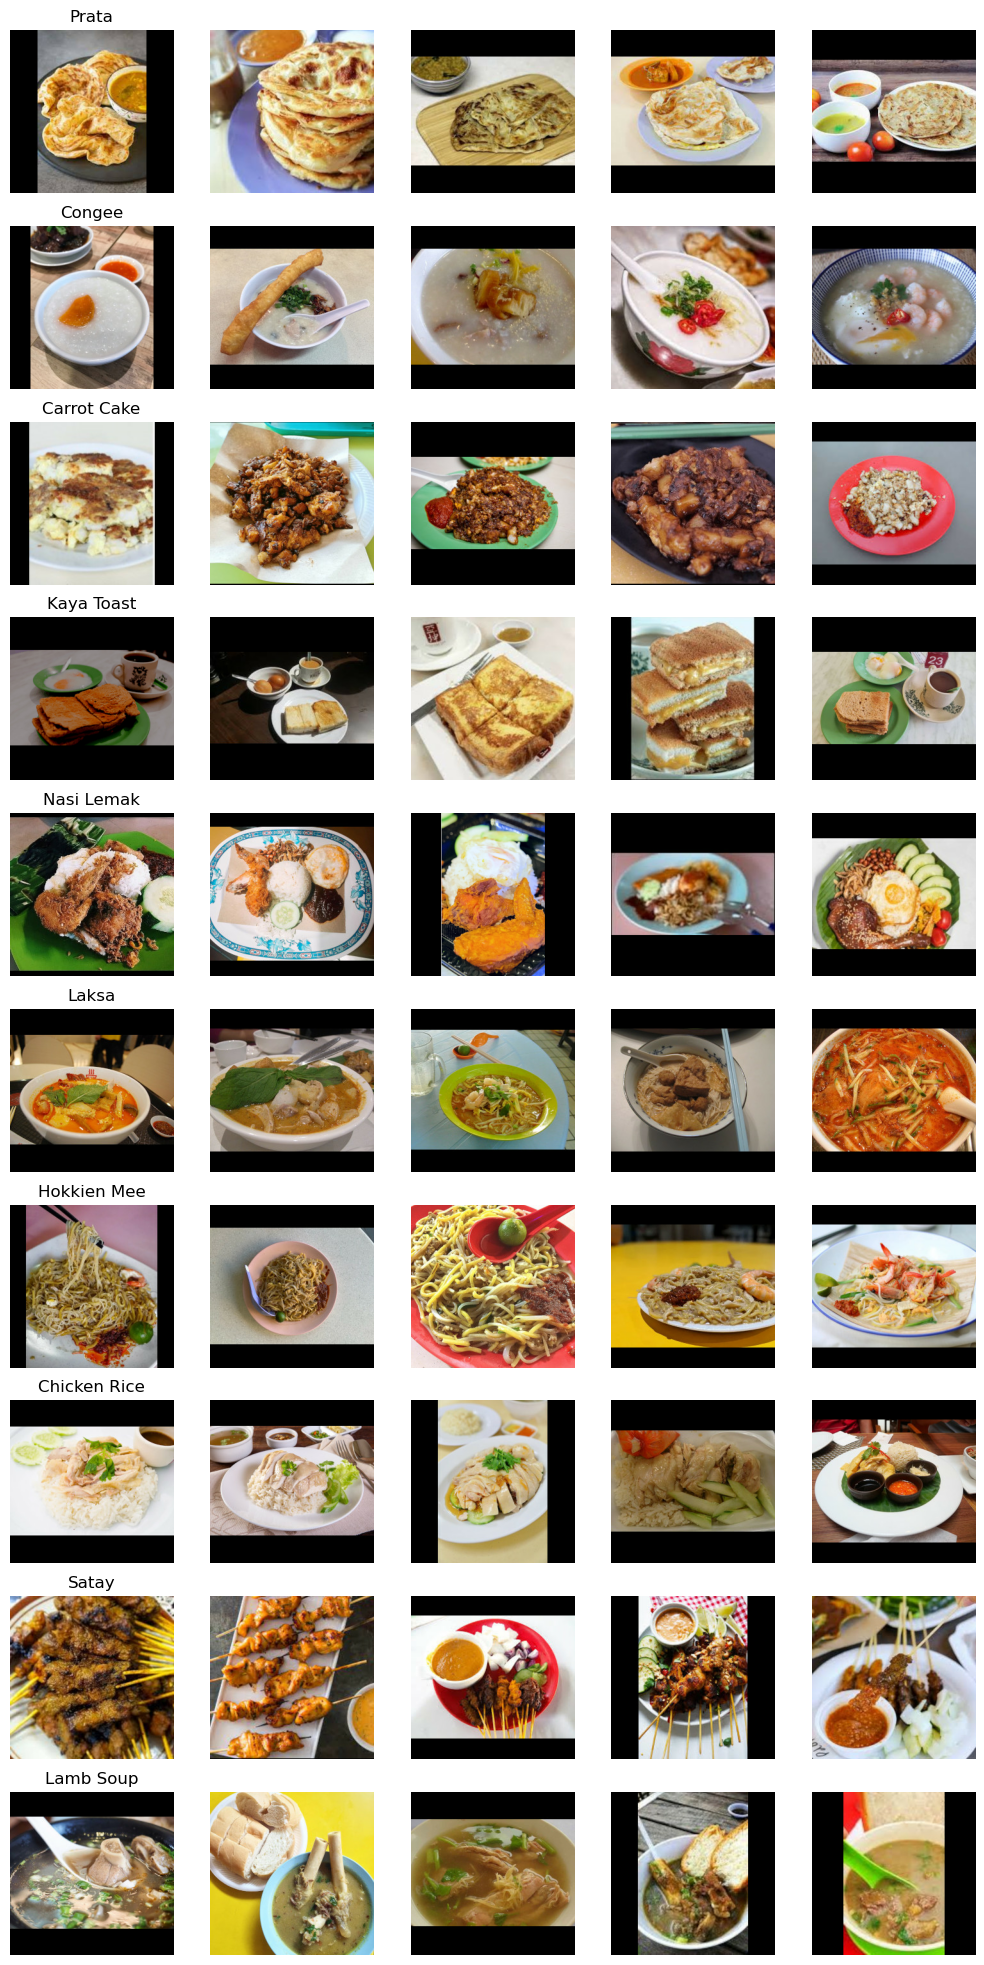

In [13]:
examplesByClass(ds, 5)

# Pre-processing

## Data Augmentation

### Oversampling

In [14]:
oversample_w_augmentation_label_seed = randint()
oversample_w_augmentation_oversample_seed = randint()

In [15]:
def oversampleWAugmentation(ds, unique_labels, class_counts, target_count, augments):
  """
  Oversample With Augmentation

  Parameters
  ----------
  ds : tf.data.Dataset
    Dataset to draw data from

    Does not get mutated

  unique_labels : int[]
    Unique labels of ds

  class_counts : int[]
    Number of samples for each label in unique_labels
  
  target_count : int
    Number of samples per class to end up w/

  augments : (func, float)[]
    (mapX function, percentage of augments which this augment accounts for)[]
  """
  datasets = []

  # Final augment is handled slightly differently
  final_augment = augments.pop()

  for i, class_count in enumerate(class_counts):
    label_ds = batch(ds.unbatch().filter(filterByLabel(unique_labels[i])))

    def oversample(augment_count, fn):
      global mapX
      nonlocal class_count, label_ds
      augment_ds = batch(mapX(
        # Data to be augmented
        label_ds.unbatch().take(augment_count),
        fn
      ))
      # Add augmented data to overall oversampled data
      datasets.append(augment_ds)
      return augment_ds

    overall_augment_count = remaining_augment_count = target_count - class_count
    for (fn, pct) in augments:
      count = np.round(overall_augment_count * pct)
      augment_ds = oversample(count, fn)
      # Add newly augmented data for next augmentation
      label_ds = tf.data.Dataset.sample_from_datasets([label_ds, augment_ds], seed=oversample_w_augmentation_label_seed)
      class_count += count
      remaining_augment_count -= count
    oversample(remaining_augment_count, final_augment[0])

  return tf.data.Dataset.sample_from_datasets(datasets, seed=oversample_w_augmentation_oversample_seed)

#### Recap: Samples per class

In [16]:
for label, count in enumerate(class_counts):
  print(f"{label}: {count}")

0: 100
1: 101
2: 112
3: 109
4: 106
5: 100
6: 100
7: 100
8: 100
9: 104


#### Let's balance that out, and generate more images, using Data Augmentation

I'll use the simplest of augmentations: Horizontal Flipping

In [17]:
# Not so arbitrary number
target_count = 144

oversample_ds = oversampleWAugmentation(
  ds,
  unique_labels,
  class_counts,
  target_count,
  [
    (tf.image.flip_left_right, 1)
  ]
)

##### Examples

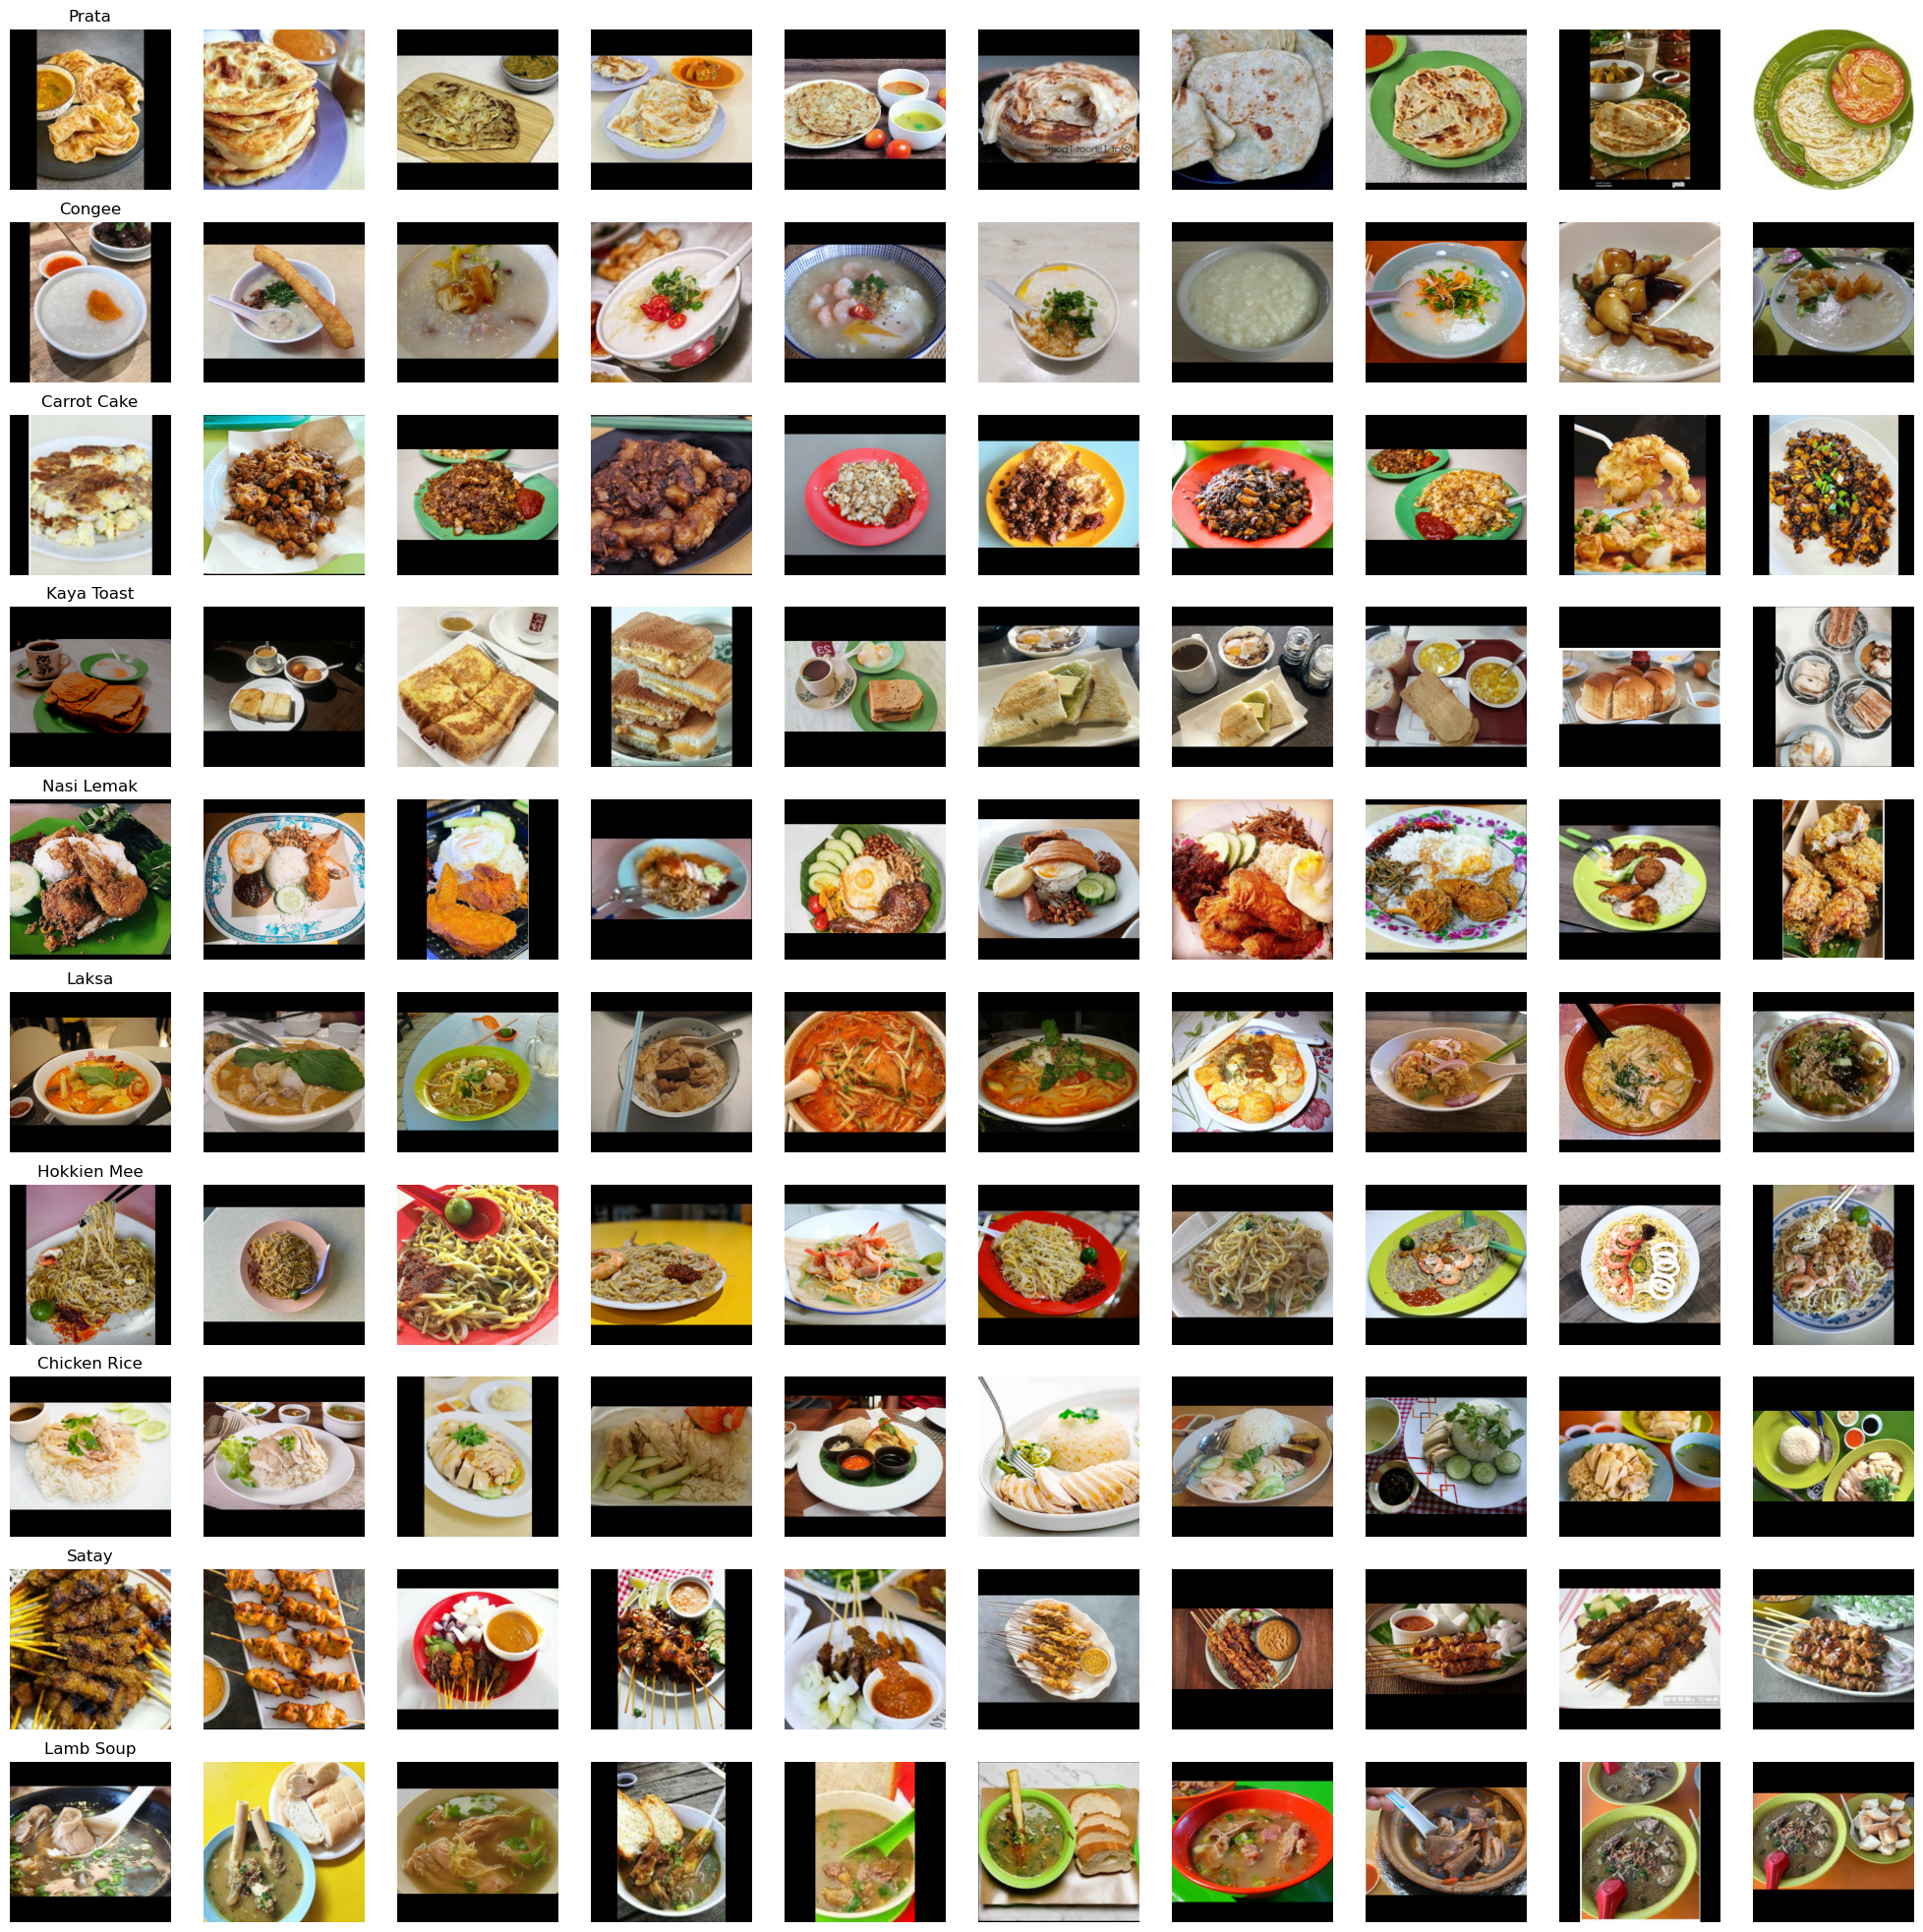

In [18]:
examplesByClass(oversample_ds, 10)

#### Now the classes should be balanced

In [19]:
oversampled_ds_seed = randint()

In [20]:
oversampled_ds = tf.data.Dataset.sample_from_datasets(
  [ds, oversample_ds],
  seed=oversampled_ds_seed
)
oversampled_labels, _, oversampled_class_counts = classInfos(oversampled_ds)

for label, count in enumerate(oversampled_class_counts):
  print(f"{label}: {count}")

0: 144
1: 144
2: 144
3: 144
4: 144
5: 144
6: 144
7: 144
8: 144
9: 144


### Training Augmentations

Nothing too aggressive.

In [21]:
crop_pct = .9

crop_size = int(np.round(image_shape[0] * crop_pct))

In [22]:
random_contrast_seed = randint()
random_crop_seed = randint()
random_rotation_seed = randint()
random_zoom_seed = randint()

In [23]:
# Will be applied later on training set in Train - Valid - Test
augmentor = tf.keras.models.Sequential(name="Augmentor")

augmentor.add(tf.keras.layers.RandomContrast(
  .1,
  seed=random_contrast_seed
))

augmentor.add(tf.keras.layers.RandomCrop(
  crop_size, crop_size,
  seed=random_crop_seed
))

augmentor.add(tf.keras.layers.RandomRotation(
  .1,
  "constant",
  seed=random_rotation_seed
))

augmentor.add(tf.keras.layers.RandomZoom(
  (-.1, .1),
  fill_mode="constant",
  seed=random_zoom_seed
))

augmentor.add(tf.keras.layers.Resizing(*target_size))

# Model

## Train - Valid -Test

Also, optimize for performance.

In [24]:
split_shuffle_seed = randint()

In [25]:
valid_pct = .1
test_pct = .1

print(f"Batch Size: {modelling_batch_size}")

size = len(oversampled_labels)
valid_size = np.round(valid_pct * size)
test_size = np.round(test_pct * size)
train_size = size - valid_size - test_size

def optimizeForModel(ds):
  return prefetch(cache(batch(ds, modelling_batch_size)))

oversampled_ds_unbatched = cache(oversampled_ds.unbatch().shuffle(size, split_shuffle_seed))
train_ds = optimizeForModel(mapX(oversampled_ds_unbatched.take(train_size), augmentor))
valid_ds = optimizeForModel(oversampled_ds_unbatched.skip(train_size).take(valid_size))
test_ds = optimizeForModel(oversampled_ds_unbatched.skip(train_size).skip(valid_size))

print(f"Train Size: {train_size}")
print(f"Valid Size: {valid_size}")
print(f"Test Size: {test_size}")

Batch Size: 32
Train Size: 1152.0
Valid Size: 144.0
Test Size: 144.0


## Layers

In [26]:
dropout_seed = randint()

In [27]:
model = tf.keras.models.Sequential(name="FoodClassifier")

model.add(tf.keras.layers.Input(image_shape))

base_model=tf.keras.applications.DenseNet201(
  include_top=False,
  weights='imagenet'
)
# Freeze Layers
for layer in base_model.layers:
    layer.trainable=False
model.add(base_model)

model.add(tf.keras.layers.GlobalAveragePooling2D(
  name="GlobalAveragePooling2D"
))
model.add(tf.keras.layers.Dropout(
  .2,
  seed=dropout_seed
))

model.add(tf.keras.layers.Dense(
  num_classes,
  activation=tf.nn.softmax,
  name="Classifier"
))

model.compile(
  tf.optimizers.Adam(
    learning_rate=0.0003
  ),
  tf.losses.categorical_crossentropy,
  tf.metrics.categorical_accuracy
)

In [28]:
model.summary()

Model: "FoodClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1920)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 Classifier (Dense)          (None, 10)                19210     
                                                                 
Total params: 18,341,194
Trainable params: 19,210
Non-trainable params: 18,321,984
_________________________________________________________________


## Fit

This will be done in batches of epochs;

1 batch will run first, then you may choose to stop there and either
1. Wait for device to cool down
2. Continue w/ the next batch
3. Proceed to `Evaluation`

In [29]:
# To keep logs from all .fit calls
history = tf.keras.callbacks.History()

def fit():
  model.fit(
    train_ds,
    epochs=epochs_per_batch,
    validation_data=valid_ds,
    callbacks=[history]
  )

Duplicate the following code cell for as many batches as desired.

In [30]:
fit()

Epoch 1/50
36/36 [==============================] - 32s 393ms/step - loss: 2.4105 - categorical_accuracy: 0.1415 - val_loss: 2.0571 - val_categorical_accuracy: 0.2778
Epoch 2/50
36/36 [==============================] - 7s 184ms/step - loss: 1.9401 - categorical_accuracy: 0.3220 - val_loss: 1.6760 - val_categorical_accuracy: 0.4931
Epoch 3/50
36/36 [==============================] - 7s 185ms/step - loss: 1.6384 - categorical_accuracy: 0.4983 - val_loss: 1.3900 - val_categorical_accuracy: 0.6806
Epoch 4/50
36/36 [==============================] - 7s 185ms/step - loss: 1.3934 - categorical_accuracy: 0.6259 - val_loss: 1.1765 - val_categorical_accuracy: 0.7639
Epoch 5/50
36/36 [==============================] - 7s 186ms/step - loss: 1.1790 - categorical_accuracy: 0.7161 - val_loss: 1.0135 - val_categorical_accuracy: 0.8403
Epoch 6/50
36/36 [==============================] - 7s 186ms/step - loss: 1.0366 - categorical_accuracy: 0.7778 - val_loss: 0.8889 - val_categorical_accuracy: 0.8681
Epo

In [36]:
fit()

Epoch 1/50
36/36 [==============================] - 7s 186ms/step - loss: 0.1500 - categorical_accuracy: 0.9852 - val_loss: 0.1737 - val_categorical_accuracy: 0.9514
Epoch 2/50
36/36 [==============================] - 7s 183ms/step - loss: 0.1517 - categorical_accuracy: 0.9774 - val_loss: 0.1678 - val_categorical_accuracy: 0.9583
Epoch 3/50
36/36 [==============================] - 7s 184ms/step - loss: 0.1486 - categorical_accuracy: 0.9809 - val_loss: 0.1646 - val_categorical_accuracy: 0.9514
Epoch 4/50
36/36 [==============================] - 7s 185ms/step - loss: 0.1451 - categorical_accuracy: 0.9826 - val_loss: 0.1616 - val_categorical_accuracy: 0.9514
Epoch 5/50
36/36 [==============================] - 7s 184ms/step - loss: 0.1358 - categorical_accuracy: 0.9844 - val_loss: 0.1619 - val_categorical_accuracy: 0.9514
Epoch 6/50
36/36 [==============================] - 7s 185ms/step - loss: 0.1371 - categorical_accuracy: 0.9861 - val_loss: 0.1627 - val_categorical_accuracy: 0.9514
Epoc

# Evaluation

## Metrics

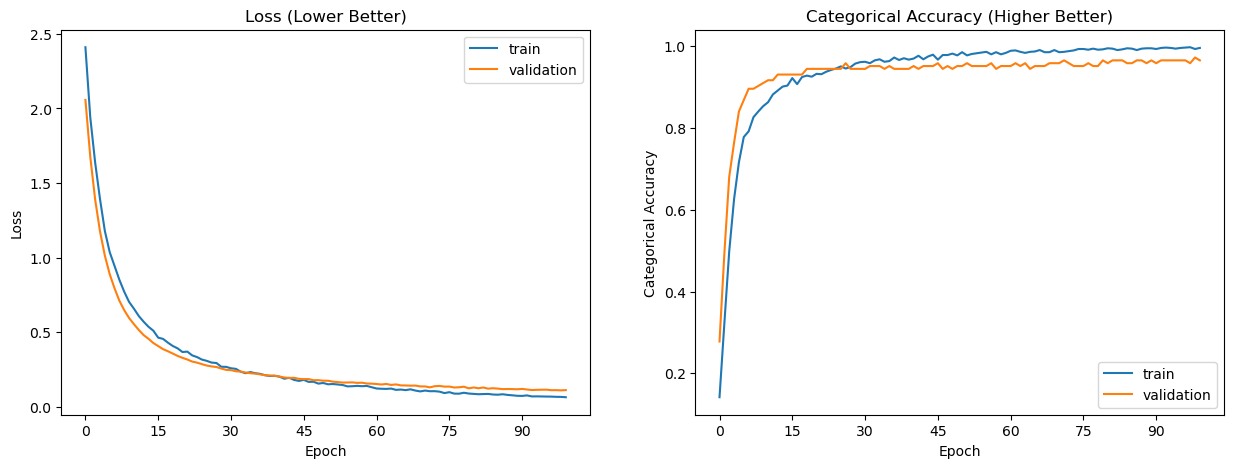

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

def plotMetric(ax, history, key, name, legend_loc, is_loss):
  ax.plot(history[key])
  ax.plot(history[f"val_{key}"])
  better = "Lower" if is_loss else "Higher"
  ax.set_title(f"{name} ({better} Better)")
  ax.set(xlabel='Epoch', ylabel=name)
  ax.legend(['train', 'validation'], loc=legend_loc)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

logs = history.history
plotMetric(ax1, logs, "loss", "Loss", "upper right", True)
plotMetric(ax2, logs, tf.metrics.categorical_accuracy.__name__, "Categorical Accuracy", "lower right", False)

In [38]:
@tf.function
def extractY(x, y):
  return y

y_test = list(prefetch(test_ds.map(extractY)).unbatch())
y_pred = model.predict(test_ds)

def testMetric(metric):
  return tf.reduce_mean(metric(y_test, y_pred)).numpy()

test_loss = testMetric(tf.losses.categorical_crossentropy)
test_acc = testMetric(tf.metrics.categorical_accuracy)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_acc}")

5/5 [==============================] - 1s 188ms/step
Loss: 0.055238738656044006
Accuracy: 1.0


## Wrongly classified images

In [39]:
@tf.function
def addPred(images, label_categoricals):
  preds = model(tf.convert_to_tensor(images), training=False)
  return images, tf.argmax(label_categoricals, 1), tf.argmax(preds, 1)

@tf.function
def isWrong(i, v):
  return tf.not_equal(v[1], v[2])

class_names_tensor = tf.convert_to_tensor(class_names)
@tf.function
def reduceToClass(i, v):
  images, label_categoricals, preds = v
  class_names = tf.gather(class_names_tensor, label_categoricals)
  wrong_class_names = tf.gather(class_names_tensor, preds)
  return images, tf.strings.join([class_names, wrong_class_names], separator=" as ")

wrong_ds = prefetch(map(
  batch(
    map(test_ds, addPred)
      .unbatch()
      .enumerate()
      .filter(isWrong)
  ),
  reduceToClass
)).unbatch()
wrong_list = list(wrong_ds)
num_wrong = len(wrong_list)

In [40]:
# Visualize
rows = 3

plt.figure(figsize=(rows * 1.3 * sf, np.ceil(num_wrong / rows) * 3.5 * sf))
for i, (image, title) in enumerate(wrong_ds):
  plt.subplot(num_wrong, rows, i + 1)
  plt.imshow(image)
  plt.title(title.numpy().decode("utf-8"))
  plt.axis("off")

<Figure size 975x0 with 0 Axes>

No mistakes. Impressive.

# Save `model`

In [44]:
model.save("model", save_format="tf")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
